# Features Selection
This notebook will explore several features and find which performs the best. 

#### Add Features:

In [ ]:
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.momentum import WilliamsRIndicator
from ta.volatility import AverageTrueRange

def feature_engineering(df, df_sp):
    # Convert timestamp to Unix time (int64) for efficiency
    df['timestamp'] = pd.to_datetime(df['timestamp']).astype('int64') // 10**9
    df_sp['timestamp'] = pd.to_datetime(df_sp['timestamp']).astype('int64') // 10**9
    
    # Sort data by symbol and timestamp
    df = df.sort_values(by=['symbol', 'timestamp'])
    df_sp = df_sp.sort_values(by=['symbol', 'timestamp'])
    
    # Time-based features
    df['hour'] = (df['timestamp'] // 3600) % 24  # Extract hour from timestamp
    df['minute'] = (df['timestamp'] // 60) % 60  # Extract minute from timestamp
    df['day_of_week'] = (df['timestamp'] // 86400) % 7  # Day of the week
    df['is_market_open'] = ((df['hour'] == 9) & (df['minute'] >= 30)) | ((df['hour'] == 10) & (df['minute'] == 0))
    df['is_market_close'] = ((df['hour'] == 15) & (df['minute'] >= 30)) | ((df['hour'] == 16) & (df['minute'] == 0))
    
    # Price change features
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df['volatility'] = df['log_return'].rolling(window=10).std()
    df['price_change'] = df['close'] - df['close'].shift(1)
    df['high_low_spread'] = df['high'] - df['low']
    df['open_close_spread'] = df['close'] - df['open']
    
    # Volume features
    df['volume_change'] = df['volume'].diff()
    df['trade_count_change'] = df['trade_count'].diff()
    df['relative_volume'] = df['volume'] / df.groupby('symbol')['volume'].transform(lambda x: x.rolling(10, min_periods=1).mean())
    
    # Rolling window features
    df['rolling_mean'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(10, min_periods=1).mean())
    df['rolling_std'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(10, min_periods=1).std())
    df['rolling_vwap'] = df.groupby('symbol')['vwap'].transform(lambda x: x.rolling(10, min_periods=1).mean())
    
    # Calculate RSI for each symbol (group by 'symbol')
    rsi = df.groupby('symbol')['close'].apply(lambda x: RSIIndicator(x, window=14).rsi()).reset_index(level=0, drop=True)
    df['rsi'] = rsi
    
    # Calculate MACD for each symbol (group by 'symbol')
    macd = df.groupby('symbol')['close'].apply(lambda x: MACD(x).macd()).reset_index(level=0, drop=True)
    df['macd'] = macd
    
    # Bollinger Bands for the entire DataFrame
    bb = BollingerBands(df['close'])
    df['bollinger_hband'] = bb.bollinger_hband()
    df['bollinger_lband'] = bb.bollinger_lband()

    df['roc'] = df.groupby('symbol')['close'].pct_change(periods=10)
    df['williams_r'] = df.groupby('symbol').apply(lambda x: WilliamsRIndicator(x['high'], x['low'], x['close'], lbp=14).williams_r()).reset_index(level=0, drop=True)
    df['atr'] = df.groupby('symbol').apply(lambda x: AverageTrueRange(x['high'], x['low'], x['close'], window=14).average_true_range()).reset_index(level=0, drop=True)
    df['hist_volatility'] = df['log_return'].rolling(20).std()
    df['rsi_macd_combo'] = df['rsi'] * df['macd']
    df['bollinger_width'] = df['bollinger_hband'] - df['bollinger_lband']

    # Target variable: price movement in 10 minutes
    df['future_close'] = df.groupby('symbol')['close'].shift(-10)
    threshold = 0.005  # 0.5% change
    df['target'] = np.where(df['future_close'] > (df['close'] * (1 + threshold)), 1, np.where(df['future_close'] < (df['close'] * (1 - threshold)), 2, 0))
    df['target'] = df['target'].astype(np.int8)

    # Add S&P 500 features to the main DataFrame
    df_sp["sp_return_1m"] = df_sp["close"].pct_change(1)   # 1-minute return
    df_sp["sp_return_10m"] = df_sp["close"].pct_change(10)   # 5-minute return
    df_sp["sp_return_1h"] = df_sp["close"].pct_change(60)  # 1-hour return
    df_sp["sp_return_1d"] = df_sp["close"].pct_change(390) # 1-day return (assuming 390 minutes per trading day)
    df_sp["sp_sma"] = df_sp["close"].rolling(window=10).mean()
    df_sp['sp_log_return'] = np.log(df_sp['close'] / df_sp['close'].shift(1))
    df_sp['sp_volatility'] = df_sp['sp_log_return'].rolling(window=10).std()
    df_sp = df_sp[['timestamp', 'sp_return_1m', 'sp_return_10m', 'sp_return_1h', 'sp_return_1d', 'sp_sma', 'sp_volatility', 'sp_log_return']]
    df = df.merge(df_sp, on='timestamp', how='left')
    
    # Drop rows with NaN values
    df = df.dropna()
    
    return df.astype({  # Convert to optimized dtypes
        'hour': np.int8,
        'minute': np.int8,
        'day_of_week': np.int8,
        'is_market_open': np.int8,
        'is_market_close': np.int8,
        'target': np.int8
    })

# Read nasdaq 100 data
file_path = "./data/raw/raw__nasdaq100_2024.parquet"
df = pd.read_parquet(file_path, engine="pyarrow")

# Read S&P 500 data
file_path_sp = "./data/raw/raw__sp500_2024.parquet"
df_sp = pd.read_parquet(file_path_sp, engine="pyarrow")

df = feature_engineering(df, df_sp)

C:\Users\aolivest\AppData\Local\Temp\ipykernel_4472\364005687.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['williams_r'] = df.groupby('symbol').apply(lambda x: WilliamsRIndicator(x['high'], x['low'], x['close'], lbp=14).williams_r()).reset_index(level=0, drop=True)
C:\Users\aolivest\AppData\Local\Temp\ipykernel_4472\364005687.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['atr'] = df.gro

#### Select features to test

In [ ]:
df_features = df[["minute", "hour", "sp_sma", "sp_return_10m", "volatility", "sp_volatility", "hist_volatility", "atr", "is_market_open", "is_market_close", "trade_count", "volume", "rsi", "roc", "target"]]

#### Feature Importance:

In [75]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Scale för att balansera datasettet
target_counts = df_features['target'].value_counts()
hold = target_counts[0]  # Håll

# Beräkna vikterna för varje klass
weights = df_features['target'].map(lambda x: hold / target_counts[x])

# Antag att vi har en "target" (t.ex. framtida avkastning)
X = df_features.drop(columns=["target"])
y = df_features["target"]

# Dela upp data i träning och test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skapa DMatrix med vikter
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights[:len(X_train)])  # Vikterna för träningsdata
dtest = xgb.DMatrix(X_test, label=y_test)

# Definiera hyperparametrar för XGBoost utan scale_pos_weight
params = {
    "objective": "multi:softmax",
    "num_class": 3,
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "mlogloss",
}

# Träna modellen
num_round = 100
model = xgb.train(params, dtrain, num_round)

# Prediktera på testsetet
y_pred = model.predict(dtest)

# Om du har fler än två klasser, använd round för att omvandla prediktioner till klasser
y_pred = y_pred.round()

# Utvärdera modellen
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Hämta feature importance
importance = model.get_score(importance_type='weight')  # 'weight' visar hur ofta en feature används

# Sortera funktionerna efter betydelse
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Visa de viktigaste funktionerna
for feature, score in sorted_importance:
    print(f"Feature: {feature}, Score: {score}")


Accuracy: 0.8441991439513404
              precision    recall  f1-score   support

           0       0.85      0.99      0.92    613394
           1       0.49      0.13      0.20     59782
           2       0.53      0.06      0.10     59259

    accuracy                           0.84    732435
   macro avg       0.62      0.39      0.41    732435
weighted avg       0.80      0.84      0.79    732435

Feature: sp_sma, Score: 2655.0
Feature: minute, Score: 2235.0
Feature: hist_volatility, Score: 1981.0
Feature: sp_volatility, Score: 1776.0
Feature: atr, Score: 1720.0
Feature: trade_count, Score: 1505.0
Feature: volume, Score: 1343.0
Feature: sp_return_10m, Score: 1281.0
Feature: volatility, Score: 1266.0
Feature: rsi, Score: 1142.0
Feature: roc, Score: 944.0
Feature: is_market_close, Score: 660.0
Feature: is_market_open, Score: 175.0


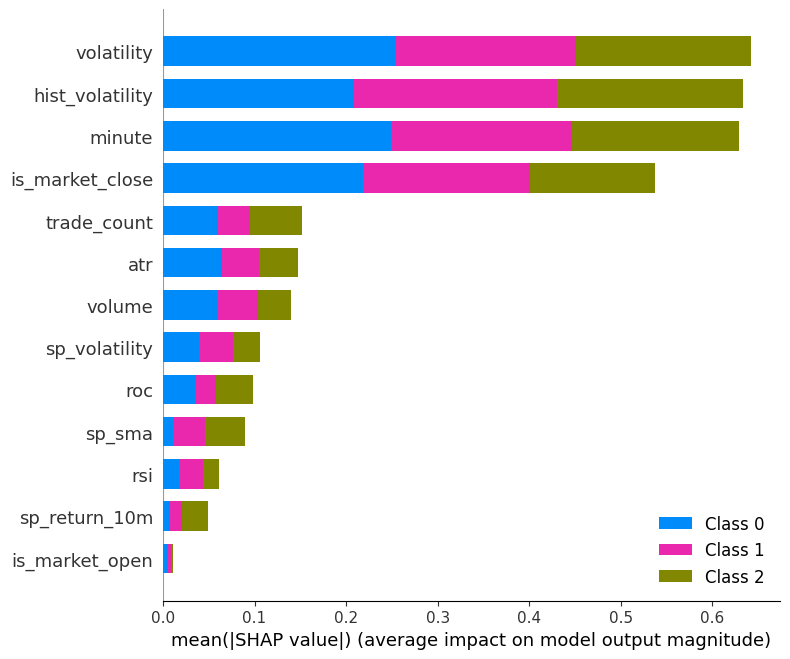

In [77]:
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Beräkna SHAP-värden
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualisera feature importance
shap.summary_plot(shap_values, X_test)


minute: [0.24891554 0.19749184 0.18265371]
sp_sma: [0.01145038 0.03432363 0.04377341]
sp_return_10m: [0.00799194 0.01297588 0.02782274]
volatility: [0.25405478 0.19671948 0.19105478]
sp_volatility: [0.03981106 0.03678036 0.02943932]
hist_volatility: [0.20883615 0.2219515  0.20225464]
atr: [0.06400547 0.04076576 0.0425287 ]
is_market_open: [0.00553778 0.00314197 0.00221685]
is_market_close: [0.2189986  0.18208994 0.1360663 ]
trade_count: [0.06033729 0.03462446 0.05682098]
volume: [0.05916476 0.04467848 0.03575773]
rsi: [0.01702623 0.02690913 0.01759155]
roc: [0.03617722 0.02214726 0.03954532]


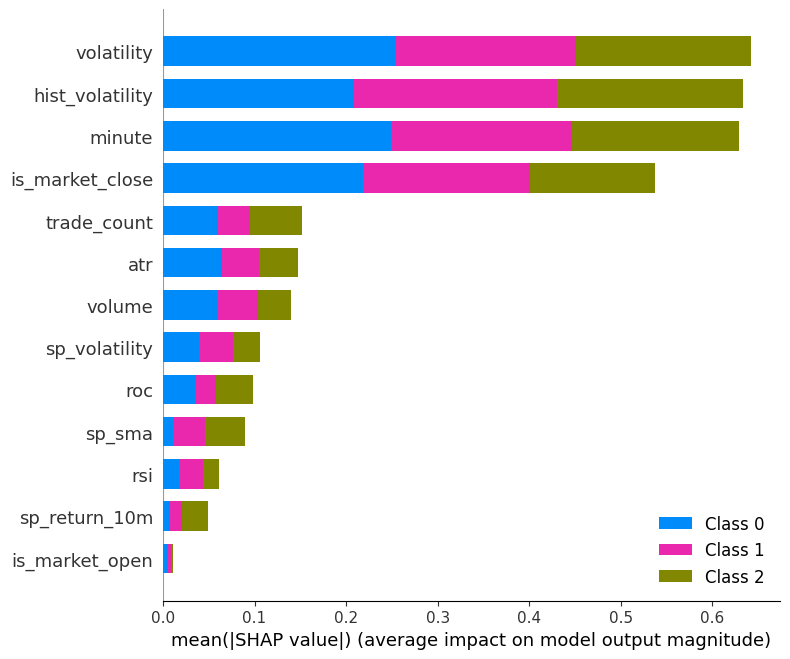

In [78]:
# Get the feature importances as text:
feature_importance = shap.summary_plot(shap_values, X_test, show=False)

# Extract feature importance and sort them
shap_importance_values = np.abs(shap_values.values).mean(axis=0)  # Mean absolute SHAP values
shap_feature_names = X_test.columns

for i, importance in enumerate(shap_importance_values):
    print(f"{shap_feature_names[i]}: {importance}")



In [41]:
from itertools import combinations
from sklearn.metrics import accuracy_score

best_score = 0
best_features = None

all_features = ["open", "high", "low", "close", "volume", "trade_count", "vwap", "hour", "minute", "day_of_week",
                "is_market_open", "is_market_close", "SMA50", "SMA200", "EMA50", "RSI", "EMA12", "EMA26",
                "MACD", "MACD_signal", "SMA20", "stddev20", "upper_band", "lower_band", "log_return", "volatility"]

# Testa alla kombinationer med t.ex. 5 features åt gången
tets = 0
for feature_set in combinations(all_features, 5):
    tets += 1
print(f"Total combinations: {tets}")

Total combinations: 65780
